In [1]:
# General libraries
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

# Deep learning libraries
# import keras
import tensorflow as tf
import keras
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


# Setting seeds for reproducibility
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

2024-06-27 04:55:45.895300: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 04:55:45.895428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 04:55:46.166154: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


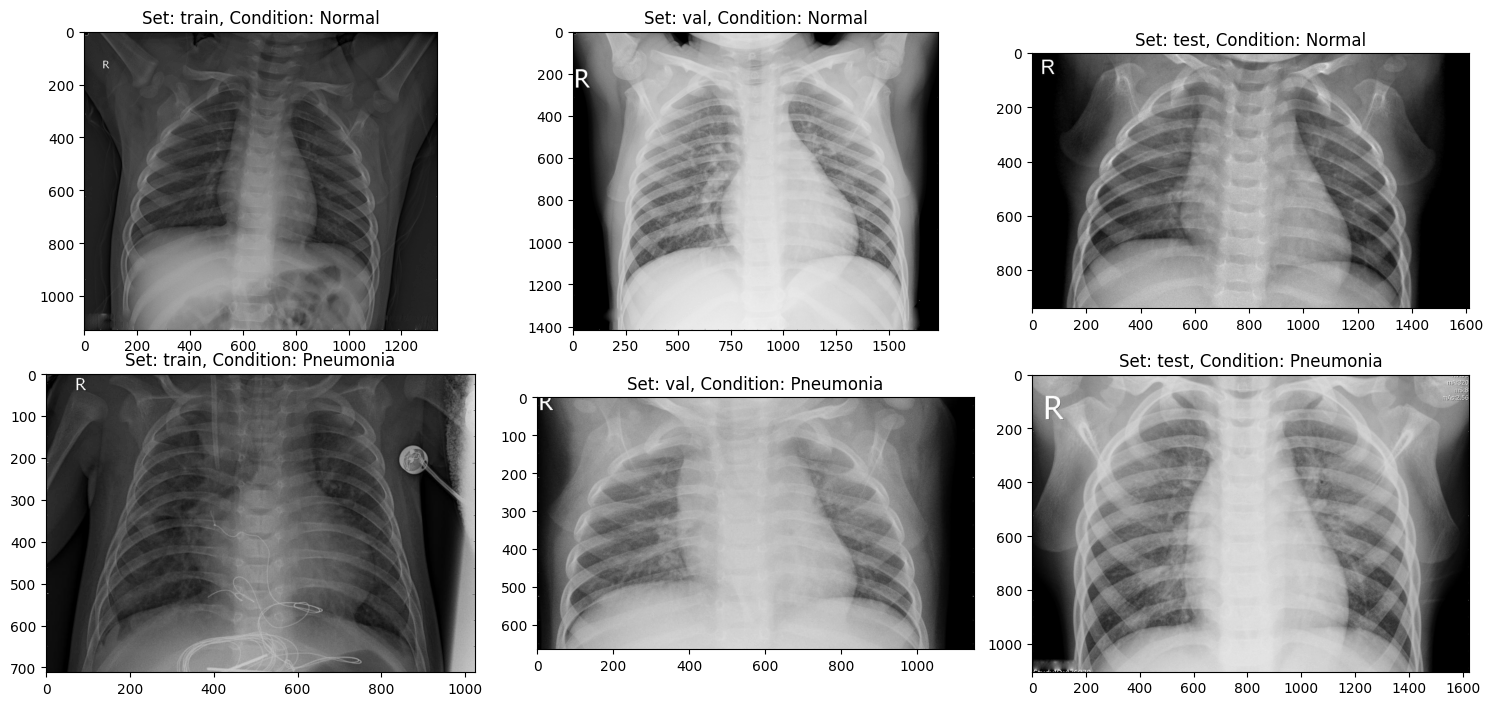

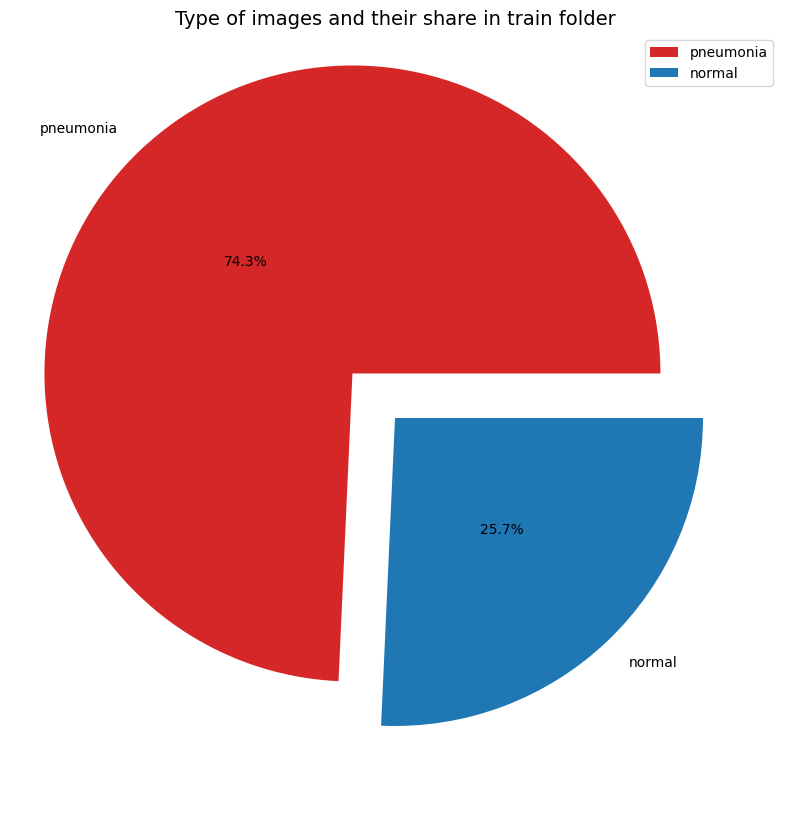

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np

input_path = '../input/chest-xray-pneumonia/chest_xray/chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = os.path.join(input_path, _set)
    ax[i].imshow(plt.imread(os.path.join(set_path, 'NORMAL', os.listdir(os.path.join(set_path, 'NORMAL'))[0])), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(os.path.join(set_path, 'PNEUMONIA', os.listdir(os.path.join(set_path, 'PNEUMONIA'))[0])), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

# Counting the number of images in the train set
train_path = os.path.join(input_path, 'train')
normal_train_images = os.listdir(os.path.join(train_path, 'NORMAL'))
pneumonia_train_images = os.listdir(os.path.join(train_path, 'PNEUMONIA'))

plt.figure(figsize=(15, 10))
patches, labels, _ = plt.pie(x=np.array([len(pneumonia_train_images), len(normal_train_images)]), autopct="%.1f%%", explode=[0.2,0], labels=["pneumonia", "normal"], pctdistance=0.5, colors=['tab:red', 'tab:blue'])
plt.title("Type of images and their share in train folder", fontsize=14)
plt.legend(labels=["pneumonia", "normal"], loc="best")
plt.show()

In [4]:
# Distribution of our datasets
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1342, pneumonia images: 3876
Set: val, normal images: 9, pneumonia images: 9
Set: test, normal images: 234, pneumonia images: 390


In [5]:
# input_path = '../input/chest_xray/chest_xray/'
input_path = '../input/chest-xray-pneumonia//chest_xray/chest_xray/'

def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [6]:
# Hyperparameters
img_dims = 150
epochs = 15
batch_size = 32

# Getting the data
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
# Input layer
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=1024, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=1024, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=1024, activation='relu')(x) 
x = Dropout(rate=0.7)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=256, activation='relu')(x)  
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [8]:
# Fitting the model
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

/tmp/ipykernel_34/3994686833.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/15


2024-06-27 04:56:23.026646: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1719464189.843560     124 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 [==============================] - 133s 720ms/step - loss: 0.4214 - accuracy: 0.7951 - val_loss: 0.8659 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 2/15
163/163 [==============================] - 79s 486ms/step - loss: 0.3058 - accuracy: 0.8612 - val_loss: 0.6628 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/15
163/163 [==============================] - 78s 479ms/step - loss: 0.2906 - accuracy: 0.8779 - val_loss: 1.4004 - val_accuracy: 0.6299 - lr: 0.0010
Epoch 4/15
163/163 [==============================] - 78s 475ms/step - loss: 0.2670 - accuracy: 0.8915 - val_loss: 4.7457 - val_accuracy: 0.6316 - lr: 0.0010
Epoch 5/15
163/163 [==============================] - 79s 482ms/step - loss: 0.2520 - accuracy: 0.8969 - val_loss: 0.3733 - val_accuracy: 0.8701 - lr: 0.0010
Epoch 6/15
163/163 [==============================] - ETA: 0s - loss: 0.2228 - accuracy: 0.9128
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 78s 4

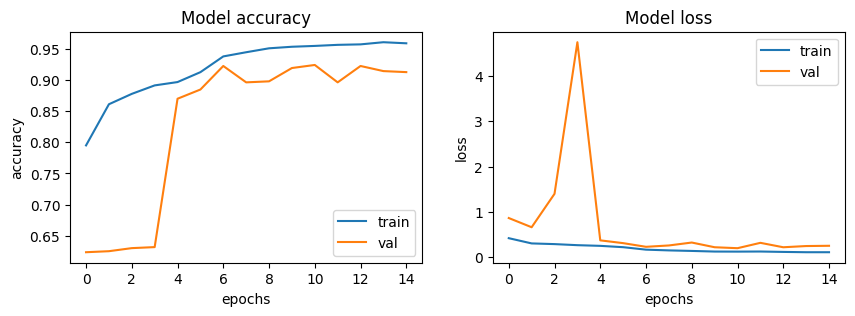

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

20/20 [==============================] - 3s 108ms/step


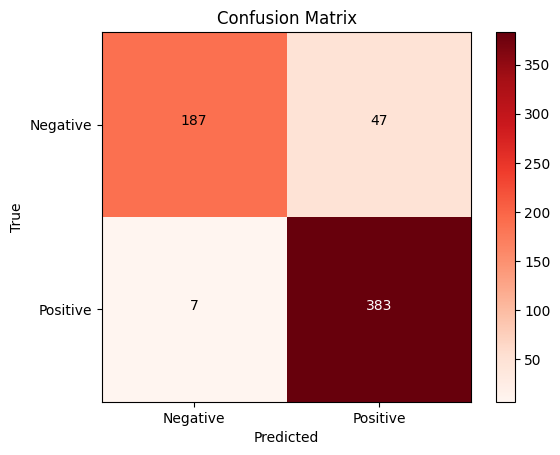


TEST METRICS ----------------------
Accuracy: 91.35%
Precision: 89.07%
Recall: 98.21%
F1-score: [  93. 8747.]

TRAIN METRIC ----------------------
Train Accuracy: 95.92


In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

# Plot the confusion matrix
plt.imshow(cm, cmap='Reds')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])

# Place the values inside the boxes
thresh = cm.max() / 2
for i in range(2):
    for j in range(2):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

# Display the plot
plt.show()

# print('CONFUSION MATRIX ------------------')
# print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(np.round(acc,2)))
print('Precision: {}%'.format(np.round(precision,2)))
print('Recall: {}%'.format(np.round(recall,2)))
print('F1-score: {}'.format(np.round(2*precision*recall/(precision+recall,2))))

print('\nTRAIN METRIC ----------------------')
print('Train Accuracy: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

In [11]:
import tensorflow as tf

# Assuming `model` is your Keras model
model.save('pneumonia_GP_CNN.h5')
model.save('pneumonia_GP_CNN.keras')
import joblib

# Save the model
# model.save('pneumonia_GP_CNN.h5')

# Load the model (if needed)
loaded_model = tf.keras.models.load_model('pneumonia_GP_CNN.h5')

# Save the model to a pickle file
joblib.dump(loaded_model, 'pneumonia_model.pkl')




/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['pneumonia_model.pkl']

In [12]:
# Get the summary of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 64)        0         
 D)                                                              
                                                                 
 separable_conv2d (Separabl  (None, 75, 75, 128)       8896      
 eConv2D)                                                        
                                                                 
 separable_conv2d_1 (Separa  (None, 75, 75, 128)       17664 

In [13]:
from sklearn.metrics import classification_report

# Assuming `model` is your trained Keras model
preds = model.predict(test_data)  # Assuming test_gen is your test generator

# Convert predictions to binary values (0 or 1)
preds_binary = np.round(preds).flatten()

# Get true labels from test generator
true_labels = test_gen.classes

# Display classification report
print(classification_report(true_labels, preds_binary, target_names=['Normal', 'Pneumonia']))

20/20 [==============================] - 1s 42ms/step
              precision    recall  f1-score   support

      Normal       0.96      0.80      0.87       234
   Pneumonia       0.89      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.89      0.90       624
weighted avg       0.92      0.91      0.91       624



# prediction

In [14]:
image='../input/chest-xray-pneumonia//chest_xray/chest_xray/test/PNEUMONIA/person101_bacteria_485.jpeg'
img = cv2.imread(str(image))

# The image is infected

1/1 [==============================] - 1s 660ms/step
The image is infected.


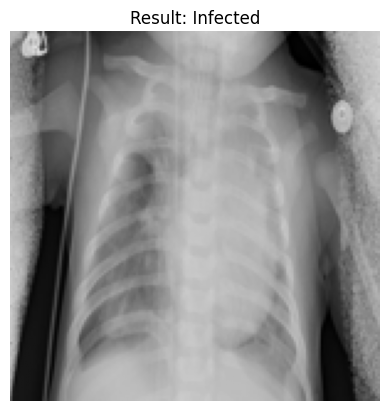

In [15]:
image_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_478.jpeg'
image = Image.open(image_path)
image = image.convert('RGB')  # Convert to RGB if necessary
image = image.resize((150, 150))
image = np.array(image) / 255.0
image = np.expand_dims(image, axis=0)

# Make the prediction
prediction = model.predict(image)

# # Interpret the result
result = np.round(prediction).astype(int)[0][0]
if result == 0:
    print("The image is not infected.")
else:
    print("The image is infected.")
# Display the image and the result
plt.imshow(image[0])
plt.axis('off')
plt.title(f"Result: {'Infected' if result == 1 else 'Not Infected'}")
plt.show()

# The image is not infected

1/1 [==============================] - 0s 20ms/step
The image is not infected.


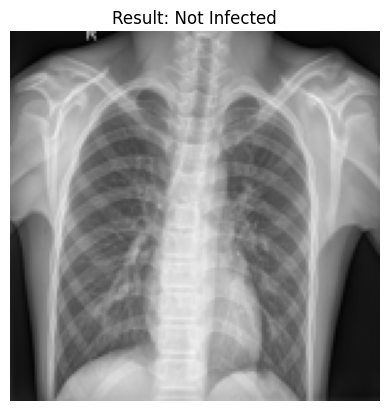

In [16]:
image_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0011-0001-0002.jpeg'
image = Image.open(image_path)
image = image.convert('RGB')  # Convert to RGB if necessary
image = image.resize((150, 150))
image = np.array(image) / 255.0
image = np.expand_dims(image, axis=0)

# Make the prediction
prediction = model.predict(image)

# # Interpret the result
result = np.round(prediction).astype(int)[0][0]
if result == 0:
    print("The image is not infected.")
else:
    print("The image is infected.")
# Display the image and the result
plt.imshow(image[0])
plt.axis('off')
plt.title(f"Result: {'Infected' if result == 1 else 'Not Infected'}")
plt.show()